In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm 
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# cd drive/MyDrive/stock/

/content/drive/MyDrive/stock


In [5]:
df = pd.read_csv("BID.csv").drop("original",1)
print(len(df))
df[df['Date']=='2014-02-24']

1761


,Date,Open,High,Low,Close,Adj Close,Volume
14,2014-02-24,16.8,16.8,16.6,16.7,12.6781,833430


In [6]:
minmax = MinMaxScaler().fit(df[['Close']].astype('float32')) # Close index
df_log = minmax.transform(df[['Close']].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_train = df_log
df_log.head()

,0
0,0.144522
1,0.135198
2,0.116550
3,0.093240
4,0.102564


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=128, num_layers=1, output_size=5):
        # super().__init__()
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.dropout = nn.Dropout(p=0.8)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1,-1), self.hidden_cell)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM().to(device) 
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
print(model)
print('device: ', device)

LSTM(
  (lstm): LSTM(5, 128)
  (dropout): Dropout(p=0.8, inplace=False)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)
device:  cpu


In [10]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [24]:
model = model.to(device)
def forecast(simulation):
  epochs = 3
  timestamp = 5
  test_size = 30
  for e, i in tqdm(enumerate(range(epochs)), total = epochs):
    # print(i)
    model.train()
    total_loss, total_acc = [], []
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
    for k in range(0, df_train.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = np.expand_dims(df_train.iloc[k : index, :].values, axis = 0)
        print(type(batch_x))
        batch_y = df_train.iloc[k + 1 : index + 1, :].values
        batch_x = torch.Tensor(batch_x).to(device)
        batch_y = torch.Tensor(batch_y).to(device)
        optimizer.zero_grad()
        # print(type(batch_x))
        # print(batch_y)
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        logits = model(batch_x)
        single_loss = loss_function(logits, batch_y)
        single_loss.backward()
        optimizer.step()
        # print(batch_y[:, 0].cpu().detach().numpy())
        # print(logits.cpu().detach().numpy())
        total_acc.append(calculate_accuracy(batch_y[:, 0].cpu().detach().numpy(),logits.cpu().detach().numpy()))
        total_loss.append(single_loss.item())
    loss_epoch = np.sum(np.array(total_loss))/len(total_loss)
        # break
    acc_epoch = np.sum(np.array(total_acc))/len(total_acc)
    if i%100 == 0:
      print("loss_epoch: {}, acc_epoch: {}".format(loss_epoch,  acc_epoch))
      # print(acc_epoch)
    
    model.eval()
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    # init_value = np.zeros((1, num_layers * 2 * size_layer))
    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = np.expand_dims(df_train.iloc[k : index, :].values, axis = 0)
        batch_y = df_train.iloc[k + 1 : index + 1, :].values
        batch_x = torch.Tensor(batch_x).to(device)
        batch_y = torch.Tensor(batch_y).to(device)
        out_logits = model(batch_x)
        # init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits.cpu().detach().numpy()[0]
        # print(output_predict)
    # print(len(output_predict))
    for i in range(future_day):
          o = output_predict[-future_day - timestamp + i:-future_day + i]
          o = np.expand_dims(o, axis = 0)
          out_logits = model(torch.Tensor(o).to(device))
          output_predict[-future_day + i] = out_logits.cpu().detach().numpy()[0]
          date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    # print(deep_future)
  torch.save(model.state_dict(), "checkpont_{}.pth".format(simulation))
  return deep_future
# forcecast()

In [42]:
results = []
simulation_size =2
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast(i))


  0%|          | 0/3 [00:00<?, ?it/s]simulation 2
loss_epoch: 0.007167457078038938, acc_epoch: 95.15688812448802
100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


In [40]:
test_size = 30
date_ori = pd.to_datetime(df['Date']).tolist()
print(date_ori[:5])
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

[Timestamp('2014-01-24 00:00:00'), Timestamp('2014-01-27 00:00:00'), Timestamp('2014-02-06 00:00:00'), Timestamp('2014-02-07 00:00:00'), Timestamp('2014-02-10 00:00:00')]


['2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24']

In [43]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

2

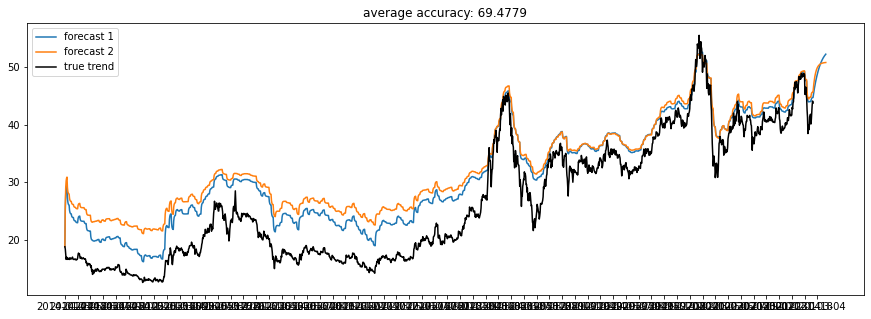

In [44]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    a = r
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()